## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    TO DO:
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [11]:
import tensorflow as tf
import keras.backend as K
#在 Keras 中，我們可以⾃自⾏行行定義函式來來進⾏行行損失的運算。⼀一個損失函數必須
#• 有 y_true 與 y_pred 兩兩個輸入
#• 必須可以微分
#• 必須使⽤用 tensor operation，也就是在 tensor 的狀狀態下，進⾏行行運算。如 K.sum …
"""
TO DO:
Write your combined loss
"""
def focal_loss_fixed(y_true, y_pred, gamma=2., alpha=4.):
    """Focal loss for multi-classification
    FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
    """
    epsilon = 1e-8
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), float(gamma)))
    fl = tf.multiply(float(alpha), tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)

def combined_loss(y_true, y_pred):
    """Define the customized loss."""
    return 0.3*focal_loss_fixed(y_true, y_pred)+0.7*keras.losses.categorical_crossentropy(y_true, y_pred)

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [12]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """
    TO DO:
    Compile your model with customized loss
    """
    model.compile(loss=combined_loss, metrics=["accuracy"], optimizer=optimizer)
    

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
___________________________________

50000/50000 [==============================] - 6s 127us/step - loss: 1.9467 - acc: 0.5431 - val_loss: 2.2706 - val_acc: 0.4715
Epoch 8/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.8773 - acc: 0.5610 - val_loss: 2.2393 - val_acc: 0.4812
Epoch 9/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.8086 - acc: 0.5753 - val_loss: 2.2314 - val_acc: 0.4826
Epoch 10/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.7466 - acc: 0.5873 - val_loss: 2.2277 - val_acc: 0.4815
Epoch 11/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.6910 - acc: 0.5991 - val_loss: 2.2199 - val_acc: 0.4814
Epoch 12/25
50000/50000 [==============================] - 7s 130us/step - loss: 1.6409 - acc: 0.6081 - val_loss: 2.2197 - val_acc: 0.4829
Epoch 13/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.5843 - acc: 0.6205 - val_loss: 2.2187 - val_acc: 0.4905
Epoch 14/25
50000/50000 [================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 161us/step - loss: 3.4328 - acc: 0.2976 - val_loss: 3.4848 - val_acc: 0.3173
Epoch 2/25
50000/50000 [==============================] - 7s 142us/step - loss: 2.5644 - acc: 0.4175 - val_loss: 2.7146 - val_acc: 0.4050
Epoch 3/25
50000/50000 [==============================] - 7s 142us/step - loss: 2.3514 - acc: 0.4588 - val_loss: 2.4936 - val_acc: 0.4296
Epoch 4/25
50000/50000 [==============================] - 7s 140us/step - loss: 2.2239 - acc: 0.4848 - val_loss: 2.4502 - val_acc: 0.4294
Epoch 5/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.1256 - acc: 0.5050 - val_loss: 2.3833 - val_acc: 0.4445
Epoch 6/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.0423 - acc: 0.5238 - val_loss: 2.3523 - val_acc: 0.4557
Epoch 7/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.9705 - acc: 0.5384 - val_loss: 2.2944 - 

50000/50000 [==============================] - 7s 139us/step - loss: 1.0858 - acc: 0.7424 - val_loss: 2.3220 - val_acc: 0.4875
Epoch 25/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.0433 - acc: 0.7511 - val_loss: 2.2941 - val_acc: 0.4964


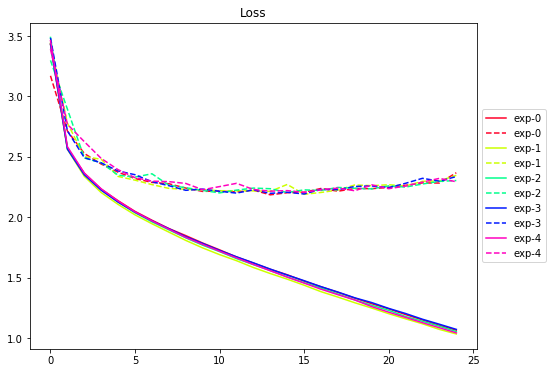

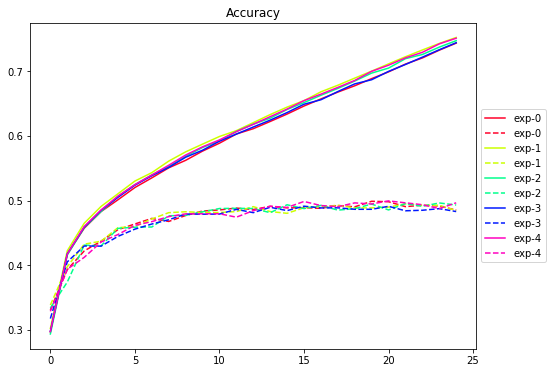

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()